<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки**  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  

**Целевой признак**  
Exited — факт ухода клиента  

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Проверим данные на дубликаты.**

In [4]:
print(data.duplicated().sum())
print(data['CustomerId'].value_counts().sum())

0
10000


**Удалим колонки 'RowNumber', 'Surname' и 'CustomerId', так как они не несут ценности для дальнейшего обучения модели.**

In [5]:
df = data.drop(['RowNumber','Surname', 'CustomerId'], axis=1)

In [6]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


**Заполним пропуски в колонке Tenure значением 0, предполагая что это ошибка в сборе данных и данные клиенты являются клиентами банка меньше 1 года.**

In [8]:
df['Tenure'] = df['Tenure'].fillna(0).astype('int64')

**Преобразуем категориальные признаки в численные. Используем метод OHE, так как он подходит для всех типов моделей.** 

In [9]:
df_ohe = pd.get_dummies(df, drop_first=True)

**Приведем признаки к одному масштабу**

In [10]:
df_ohe.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


У признаков разный масштаб. Алгоритм автоматически решит, что какие-то признаки важнее. А это не так: в нашем случае все признаки значимы. Необходимо масштабировать признаки, сделаем это с помощью стандартизации.
    

In [11]:
df_ohe['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Сначала разделим данные на обучающую и тестовую выборки, сохраняя соотношение целевого признака в обеих выборках.

In [12]:
rns = 2021

In [13]:
X = df_ohe.drop('Exited', axis=1)  
y = df_ohe['Exited'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rns, stratify=y)

Масштабируем численные признаки.

In [14]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [15]:
pd.options.mode.chained_assignment = None
ss = StandardScaler()
ss.fit(X_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
X_train[numeric] = ss.fit_transform(X_train[numeric])
X_test[numeric] = ss.transform(X_test[numeric])

**Проверим корреляцию между признаками.**

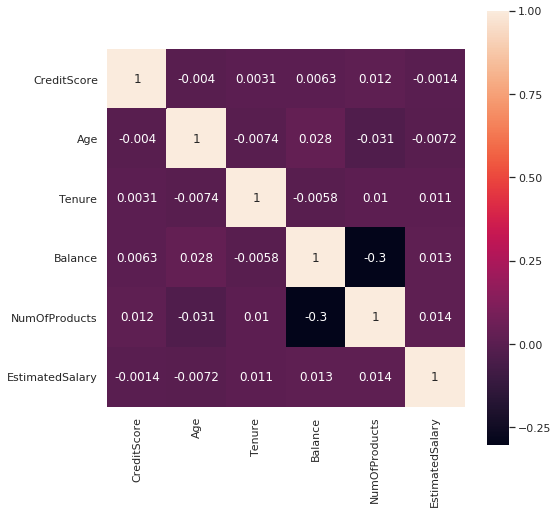

In [17]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1)
sns.heatmap(X[numeric].corr(), square = True, annot = True);

Между признаками нет сильной взаимосвязи, поэтому для обучения оставим все признаки.

**Выводы**
1. Была сделана предобработка данныx (проверка дубликатов, работа с пропусками, удалены лишние признаки)
2. Категориальные данные были закодированы методом OHE.
3. Численные признаки приведены к одному масштабу.
4. Исследована взаимосвязь между признаками.

## Исследование задачи

Попробуем построить модели без учета дисбаланса классов.

In [18]:
dt = DecisionTreeClassifier(random_state=rns)
dt.fit(X_train, y_train)
print('Accuracy DT:', dt.score(X_test, y_test))

rf = RandomForestClassifier(random_state=rns, n_estimators = 10)
rf.fit(X_train, y_train)
print('Accuracy RF:', rf.score(X_test, y_test))

lr = LogisticRegression(random_state=rns, solver = 'liblinear')
lr.fit(X_train, y_train)
print('Accuracy LR:', lr.score(X_test, y_test))

Accuracy DT: 0.809
Accuracy RF: 0.853
Accuracy LR: 0.8


В среднем доля правильных ответов 80%. Сравним этот показатель с показателем модели, которая всегда предсказывает 0.

In [19]:
y_const = pd.Series(0, index=y_test.index)
print(accuracy_score(y_test, y_const))

0.7965


Доля правильных ответов модели, которая всегда предсказывает ноль, такая же как и у обученных моделей.   
Ни одна модель не прошла проверку на адекватность. 
Метрика accuracy в данном случае не является показателем качества модели. 

Построим матрицу ошибок.

In [20]:
pred_dt = dt.predict(X_test)
pred_rf = rf.predict(X_test)
pred_lr = lr.predict(X_test)
conf_matrix_dt = pd.DataFrame(confusion_matrix(y_test, pred_dt), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_rf = pd.DataFrame(confusion_matrix(y_test, pred_rf), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
conf_matrix_lr = pd.DataFrame(confusion_matrix(y_test, pred_lr), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
print('Decision Tree')
display(conf_matrix_dt)
print('Recall:', recall_score(y_test, pred_dt))
print('Precision:', precision_score(y_test, pred_dt))
print('F1-мера:', f1_score(y_test, pred_dt))
print('-'*100)
print('Random Forest')
display(conf_matrix_rf)
print('Recall:', recall_score(y_test, pred_rf))
print('Precision:', precision_score(y_test, pred_rf))
print('F1-мера:', f1_score(y_test, pred_rf))
print('-'*100)
print('Logistic Regression')
display(conf_matrix_lr)
print('Recall:', recall_score(y_test, pred_lr))
print('Precision:', precision_score(y_test, pred_lr))
print('F1-мера:', f1_score(y_test, pred_lr))

Decision Tree


,predicted 0,predicted 1
actual 0,1407,186
actual 1,196,211


Recall: 0.5184275184275184
Precision: 0.5314861460957179
F1-мера: 0.5248756218905473
----------------------------------------------------------------------------------------------------
Random Forest


,predicted 0,predicted 1
actual 0,1538,55
actual 1,239,168


Recall: 0.41277641277641275
Precision: 0.7533632286995515
F1-мера: 0.5333333333333333
----------------------------------------------------------------------------------------------------
Logistic Regression


,predicted 0,predicted 1
actual 0,1533,60
actual 1,340,67


Recall: 0.16461916461916462
Precision: 0.5275590551181102
F1-мера: 0.250936329588015


Recall описывает, как хорошо модель разобралась в особенностях этого класса и распознала его. Precision выявляет, не переусердствует ли модель, присваивая положительные метки. F1 - это среднее гармоническое полноты и точности. Для решения нашей задачи необходимо достичь F1-меры не менее 0.59. Сначала решим проблему дисбаланса классов.

## Борьба с дисбалансом

**В данных наблюдается сильный дисбаланс классов, что плохо сказывается на обучении модели.**  
Сначала попробуем взвешивание классов.

In [21]:
print('Значение F1-меры при взвешивании классов:')
dt_cw = DecisionTreeClassifier(random_state=rns, class_weight='balanced')
dt_cw.fit(X_train, y_train)
pred_dt_cw = dt_cw.predict(X_test)
print('DT:', f1_score(y_test, pred_dt_cw))
rf_cw = RandomForestClassifier(random_state=rns, n_estimators = 10, class_weight='balanced')
rf_cw.fit(X_train, y_train)
pred_rf_cw = rf_cw.predict(X_test)
print('RF:', f1_score(y_test, pred_rf_cw))
lr_cw = LogisticRegression(random_state=rns, solver = 'liblinear', class_weight='balanced')
lr_cw.fit(X_train, y_train)
pred_lr_cw = lr_cw.predict(X_test)
print('LR:', f1_score(y_test, pred_lr_cw))

Значение F1-меры при взвешивании классов:
DT: 0.5050761421319797
RF: 0.5
LR: 0.49277978339350187


Взвешивание классов в процессе обучения улучшило модель логистической регрессии. Качество решающего дерева и случайного леса даже немного ухудшилось.

**Попробуем технику Upsampling, так как у нас не очень много данных.**

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rns)
    return features_upsampled, target_upsampled

In [23]:
X_train_up, y_train_up = upsample(X_train, y_train, 4)

Теперь классы равны.

In [24]:
y_train_up.value_counts(normalize=True)

1    0.505818
0    0.494182
Name: Exited, dtype: float64

In [25]:
print('Значение F1-меры при увеличении выборки:')
dt_up = DecisionTreeClassifier(random_state=rns)
dt_up.fit(X_train_up, y_train_up)
pred_dt_up = dt_up.predict(X_test)
print('DT:', f1_score(y_test, pred_dt_up))

rf_up = RandomForestClassifier(random_state=rns, n_estimators = 10)
rf_up.fit(X_train_up, y_train_up)
pred_rf_up = rf_up.predict(X_test)
print('RF:', f1_score(y_test, pred_rf_up))

lr_up = LogisticRegression(random_state=rns, solver = 'liblinear')
lr_up.fit(X_train_up, y_train_up)
pred_lr_up = lr_up.predict(X_test)
print('LR:', f1_score(y_test, pred_lr_up))

Значение F1-меры при увеличении выборки:
DT: 0.5167095115681235
RF: 0.5798319327731093
LR: 0.49247121346324185


## Тестирование модели

Лучший результат показала модель RF - значение F1-меры 0.57.  
Попробуем улучшить модель с помощью подбора гиперпараметров.

In [26]:
%%time

model = RandomForestClassifier(random_state=rns)
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 250, num = 25)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(model, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 2, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=rns)
rs.fit(X_train_up, y_train_up)
rs.best_params_

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.6min finished


CPU times: user 3min 40s, sys: 362 ms, total: 3min 41s
Wall time: 3min 43s


{'n_estimators': 203,
 'min_samples_split': 12,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 14,
 'bootstrap': False}

In [27]:
model_rs = rs.best_estimator_

In [28]:
predict = model_rs.predict(X_test)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predict), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix)
print('Recall:', recall_score(y_test, predict))
print('Precision:', precision_score(y_test, predict))
print('F1-мера:', f1_score(y_test, predict))

,predicted 0,predicted 1
actual 0,1422,171
actual 1,149,258


Recall: 0.6339066339066339
Precision: 0.6013986013986014
F1-мера: 0.6172248803827752


Нам удалось достичь целевого значения F1-меры.

**Исследуем метрику AUC-ROC.**

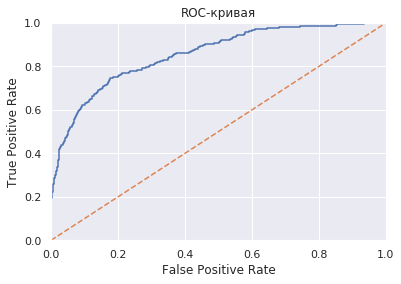

ROC-AUC: 0.8555751437107368
Accuracy: 0.84


In [30]:
probabilities_test = model_rs.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('ROC-AUC:',roc_auc_score(y_test, probabilities_one_test))
print('Accuracy:', model_rs.score(X_test, y_test))

**Выводы**  

1. В изначальных данных был дисбаланс (80%/20%), обученная на этих данных модель не проходила проверку на адекватность. У всех моделей был невысокий показатель F1-меры. Худший результат показала логистическая регрессия. У случайного леса и логистической регрессии был перекос между recall и precision. 

2. После устранения дисбаланса классов с помощью увеличения выборки, F1-мера увеличилась для всех моделей. Лучший результат показал случайный лес. После подбора гиперпараметров с помощью сетки показатель F1-меры увеличился до 0.62, ROC-AUC лучшей модели - 0.85.